# Import Dependencies

In [36]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Check the Data

In [37]:
def load_image(image_path):
  image = cv2.imread(image_path)
  if image is None:
    print('None')
    return None, None
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image, gray

In [38]:
sample_img, sample_gray = load_image('images/Ravie_Arjun/10.jpg')

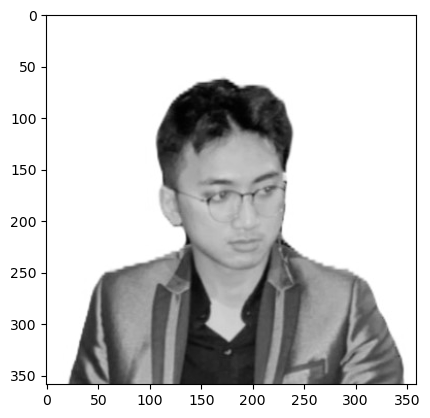

In [39]:
plt.imshow(sample_gray, cmap='gray')

# Load the Dataset

In [40]:
dataset_dir = 'images'
images = []
labels = []

for root, dirs, files in os.walk(dataset_dir):
  if len(files) == 0:
    continue
  for f in files:
    _, gray_image = load_image(os.path.join(root, f))
    if gray_image is None:
      continue
    images.append(gray_image) # list of images
    labels.append(root.split('/')[-1]) # list of labels

In [41]:
# Load the Haar Cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_frontalface_default.xml')


In [ ]:
# fungsi untuk mendeteksi wajah menggunakan model Haar Cascade sebelumnya
def detect_faces(image_gray, scale_factor=1.1, min_neighbors=5, min_size=(30, 30)):
  faces = face_cascade.detectMultiScale(
    image_gray,
    scaleFactor=scale_factor,
    minNeighbors=min_neighbors,
    minSize=min_size
  )
  return faces

In [ ]:
# proses deteksi wajah pada gambar. menghasilkan koordinat wajah yang terdeteksi dan ukuran wajah
detected_face = detect_faces(sample_gray, min_size=(50, 50))

In [ ]:
# memotong hanya pada wajah yang terdeteksi dari gambar asli
def crop_faces(image_gray, faces, return_all=False):
  cropped_faces = []
  selected_faces = []
  if len(faces) > 0:
    if return_all:
      for x, y, w, h in faces:
        selected_faces.append((x, y, w, h))
        cropped_faces.append(image_gray[y:y+h, x:x+w])
    else:
      x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])
      selected_faces.append((x, y, w, h))
      cropped_faces.append(image_gray[y:y+h, x:x+w])
  return cropped_faces, selected_faces

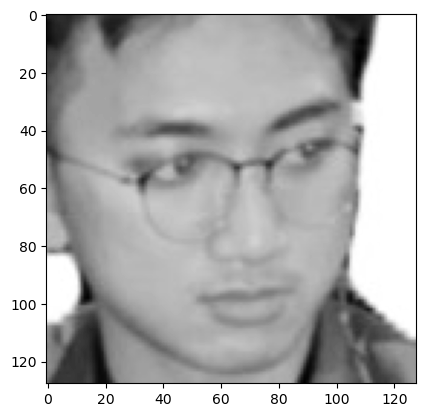

In [45]:
# menampilkan wajah yang terdeteksi pada gambar asli
cropped_face,_ = crop_faces(sample_gray, detected_face)
plt.imshow(cropped_face[0], cmap='gray')

# Recognition

In [ ]:
# fungsi bantu untuk me-resize dan meratakan wajah yang terdeteksi
face_size = (128, 128)

def resize_and_flatten(face):
  face_resized = cv2.resize(face, face_size)
  face_flattened = face_resized.flatten()
  return face_flattened

In [ ]:
# mendeteksi dan memotong wajah pada semua gambar dalam dataset lalu menyimpannya dalam array X
# dan labelnya dalam array y

X = []
y = []

for image, label in zip(images, labels):
  faces = detect_faces(image)
  cropped_face,_ = crop_faces(image, faces)
  if len(cropped_face) > 0:
    face_flattened = resize_and_flatten(cropped_face[0])
    X.append(face_flattened)
    y.append(label)

X = np.array(X)
y = np.array(y)

In [48]:
X.shape

(68, 16384)

In [ ]:
# memisahkan dataset menjadi data latih dan data uji
# 70% untuk data latih dan 30% untuk data uji

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y, shuffle=True)

In [ ]:
# menggunakan teknik mean centering untuk mengurangi dimensi data

from sklearn.base import BaseEstimator, TransformerMixin
class MeanCentering(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.mean_face = np.mean(X, axis=0)
    return self
  def transform(self, X):
    return X - self.mean_face

In [ ]:
# pipeline untuk preprocessing data dan klasifikasi
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA

pipe = Pipeline([
  ('centering', MeanCentering()),
  ('pca', PCA(svd_solver='randomized', whiten=True, random_state=177)),
  ('svc', SVC(kernel='linear', random_state=177))
])

In [52]:
from sklearn.metrics import classification_report

# melatih model dengan data latih dan menguji dengan data uji
pipe.fit(X_train, y_train)

# memprediksi data uji
y_pred = pipe.predict(X_test)

# menampilkan hasil klasifikasi
print(classification_report(y_test, y_pred))

                          precision    recall  f1-score   support

images\Cristiano_Ronaldo       0.50      0.33      0.40         3
    images\George_W_Bush       0.00      0.00      0.00         3
       images\Laura_Bush       0.50      0.67      0.57         3
     images\Lionel_Messi       0.67      0.67      0.67         3
      images\Ravie_Arjun       0.00      0.00      0.00         3
  images\Serena_Williams       0.60      1.00      0.75         3
   images\Vladimir_Putin       0.50      0.67      0.57         3

                accuracy                           0.48        21
               macro avg       0.40      0.48      0.42        21
            weighted avg       0.40      0.48      0.42        21



c:\Users\ASUS ExpertBook\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS ExpertBook\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS ExpertBook\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


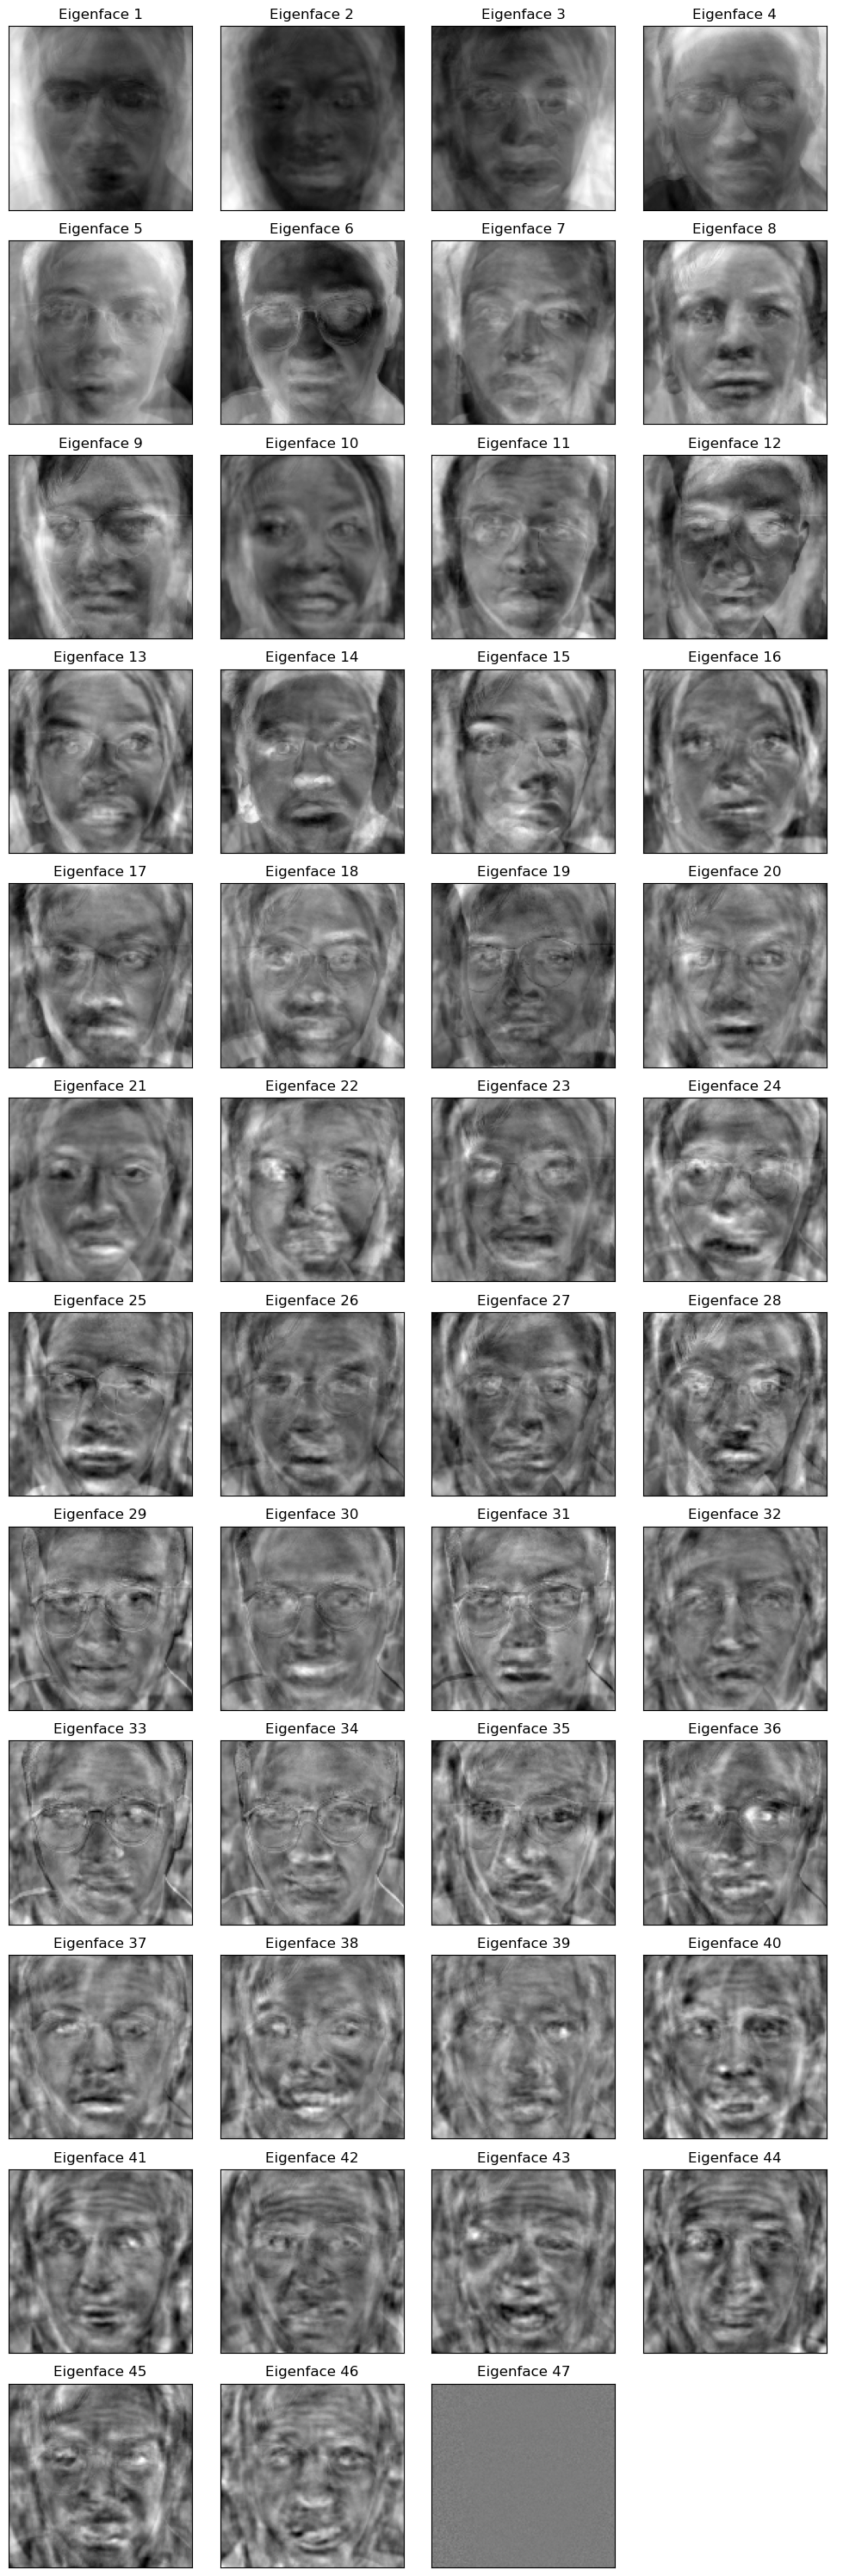

In [ ]:
n_components = len(pipe[1].components_)
ncol = 4
nrow = (n_components + ncol - 1) // ncol
fig, axes = plt.subplots(nrow, ncol, figsize=(10, 2.5*nrow),
subplot_kw={'xticks':[], 'yticks':[]})
eigenfaces = pipe[1].components_.reshape((n_components,
X_train.shape[1]))
for i, ax in enumerate(axes.flat):
  if i < n_components:  # Ensure we don't access out-of-bounds indices
    ax.imshow(eigenfaces[i].reshape(face_size), cmap='gray')
    ax.set_title(f'Eigenface {i+1}')
  else:
    ax.axis('off')  # Hide unused subplots
plt.tight_layout()
plt.show()

In [54]:
import pickle
with open('eigenface_pipeline.pkl', 'wb') as f:
  pickle.dump(pipe, f)

In [ ]:
# fungsi bantu untuk menampilkan skor eigenface
def get_eigenface_score(X):
  X_pca = pipe[:2].transform(X)
  eigenface_scores = np.max(pipe[2].decision_function(X_pca), axis=1)
  return eigenface_scores

In [ ]:
# fungsi bantu prediksi wajah serta skor eigenface-nya
def eigenface_prediction(image_gray):
  faces = detect_faces(image_gray)
  cropped_faces, selected_faces = crop_faces(image_gray, faces)
  if len(cropped_faces) == 0:
    return 'No face detected.'

  X_face = []
  for face in cropped_faces:
    face_flattened = resize_and_flatten(face)
    X_face.append(face_flattened)

  X_face = np.array(X_face)
  labels = pipe.predict(X_face)
  scores = get_eigenface_score(X_face)
  return scores, labels, selected_faces

In [ ]:
# memprediksi wajah yang terdeteksi pada gambar test
test_image, test_gray_image = load_image('images/test/Arjun01.jpg')
score, label, selected_face = eigenface_prediction(test_gray_image)

In [64]:
def draw_text(image, label, score,
              font=cv2.FONT_HERSHEY_SIMPLEX,
              pos=(0, 0),
              font_scale=0.6,
              font_thickness=2,
              text_color=(0, 0, 0),
              text_color_bg=(0, 255, 0)
              ):
  x, y = pos
  score_text = f'Score: {score:.2f}'
  (w1, h1), _ = cv2.getTextSize(score_text, font, font_scale, font_thickness)
  (w2, h2), _ = cv2.getTextSize(label, font, font_scale, font_thickness)
  cv2.rectangle(image, (x, y-h1-h2-25), (x + max(w1, w2)+20, y),text_color_bg, -1)
  cv2.putText(image, label, (x+10, y-10), font, font_scale, text_color, font_thickness)
  cv2.putText(image, score_text, (x+10, y-h2-15), font, font_scale,text_color, font_thickness)

In [59]:
def draw_result(image, scores, labels, coords):
  result_image = image.copy()
  for (x, y, w, h), label, score in zip(coords, labels, scores):
    cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    draw_text(result_image, label, score, pos=(x, y))
  return result_image

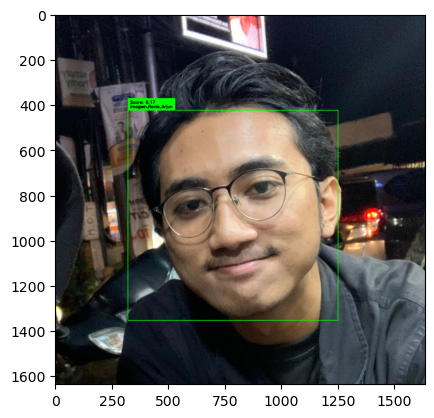

In [68]:
result_image = draw_result(test_image, score, label, selected_face)
plt.imshow(result_image)

Data test berhasil dideteksi dengan baik

# Real-Time Recognition

In [61]:
import cv2
import numpy as np

# Mulai capture dari webcam (0 artinya webcam default)
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Ubah ke grayscale agar sesuai input fungsi eigenface_prediction
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Prediksi dengan model Eigenface
    try:
        scores, labels, selected_faces = eigenface_prediction(gray_frame)

        for (x, y, w, h), label, score in zip(selected_faces, labels, scores):
            # Tampilkan bounding box dan label
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            text = f"Label: {label}, Score: {score:.2f}"
            cv2.putText(frame, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (36, 255, 12), 2)
    except Exception as e:
        # Misalnya jika tidak ada wajah terdeteksi
        cv2.putText(frame, "No face detected", (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # Tampilkan hasil
    cv2.imshow('Real-Time Eigenface Recognition', frame)

    # Tekan 'q' untuk keluar
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Bersihkan resource
cap.release()
cv2.destroyAllWindows()


KeyboardInterrupt: 

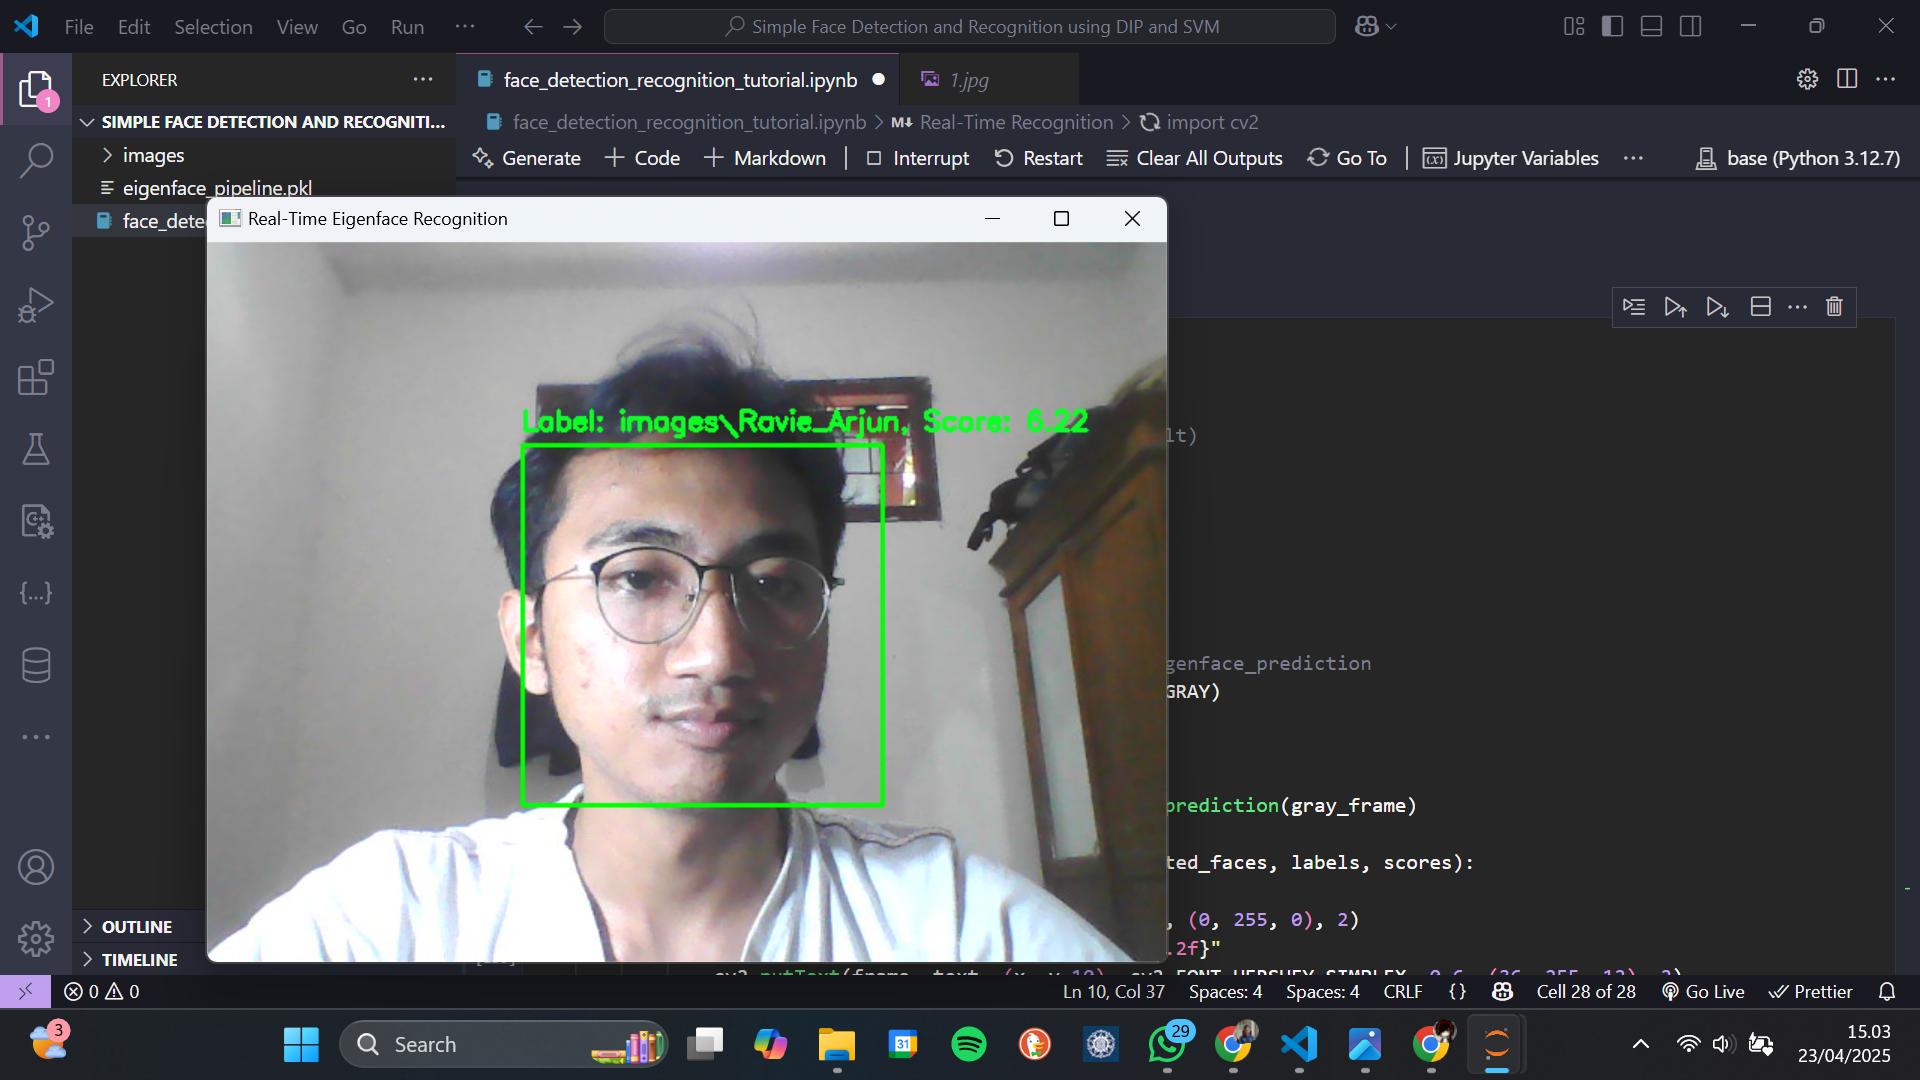